# Tutorial 5: Neural Architecture Search (NAS) with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [2]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

/rds/general/user/jj21/home/.conda/envs/adls/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads, inspired by the [NAS-BERT paper](https://arxiv.org/abs/2105.14444).

In [3]:
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_int` and `trial.suggest_categorical` functions to trigger the chosen sampler to choose parameter choices and layer types. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr


def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        setattr(config, param, search_space[param][chosen_idx])

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [5]:
from chop.tools import get_trainer


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [6]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [8]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2025-02-05 00:31:11,311] A new study created in memory with name: bert-tiny-nas-study
/rds/general/user/jj21/home/.conda/envs/adls/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/rds/general/user/jj21/home/.conda/envs/adls/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/rds/general/user/jj21/home/adlsystems/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.643000
1000,0.485800
1500,0.439200
2000,0.401200
2500,0.370700
3000,0.367800


[I 2025-02-05 00:32:30,837] Trial 0 finished with value: 0.84788 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encode

Fetch the model associated with the best trial as follows, and export to be used in future tutorials. In Tutorial 6, we'll see how to run mixed-precision quantization search on top of the model we've just found through NAS to further find the optimal quantization mapping.

In [9]:
from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"].cpu()

# with open(f"{Path.home()}/adlsystems/tutorial_5_best_model.pkl", "wb") as f:
#     dill.dump(model, f)

## Deploying the Optimized Model with CompressionPipeline

Now, we can run the CompressionPipeline in Mase to run uniform quantization and pruning over the searched model.

In [10]:
from chop.pipelines import CompressionPipeline
from chop import MaseGraph

mg = MaseGraph(model)
pipe = CompressionPipeline()

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = pipe(
    mg,
    pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    },
)

`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query


tensor([[[-0.3296, -1.4549,  0.0326,  ..., -0.1574, -0.4224,  1.6893],
         [-0.2606, -0.4572, -0.4059,  ..., -0.9441, -0.2051,  1.1130],
         [-0.8559, -0.3861,  0.5973,  ..., -1.0750, -1.3108,  0.5718],
         ...,
         [ 0.5808, -0.4137, -0.9580,  ...,  0.4668, -0.8509,  1.8223],
         [-0.5850, -0.9949, -1.2728,  ...,  1.0410, -0.9790,  0.1326],
         [-0.6275, -0.6316, -0.3701,  ..., -0.6253, -0.7213, -0.1099]],

        [[-0.7600, -1.5700, -0.0439,  ..., -0.0399, -0.3801,  1.6567],
         [-0.8535,  0.1439, -0.0452,  ..., -0.1229,  0.9606,  0.9693],
         [-0.2698, -1.1185,  0.2769,  ..., -0.2608, -0.9815,  3.9285],
         ...,
         [-0.3493,  0.3385, -0.2614,  ...,  1.5694,  0.4818,  0.2894],
         [ 0.2867, -1.0863, -1.5508,  ..., -0.5524,  1.0603,  0.4579],
         [-0.9856, -0.7443, -0.4620,  ..., -0.5505, -0.7681, -0.1295]]],
       grad_fn=<NativeLayerNormBackward0>)
tensor([[[-0.8972, -1.6752, -0.4761,  ..., -1.1622,  2.5607,  1.5923],
  

INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Finally, export the MaseGraph for the compressed checkpoint to be used in future tutorials for hardware generation and distributed deployment.

In [ ]:
mg.export(f"{Path.home()}/adlsystems/tutorial_5_nas_compressed")

Data saved to sampler_cumulative_results.csv


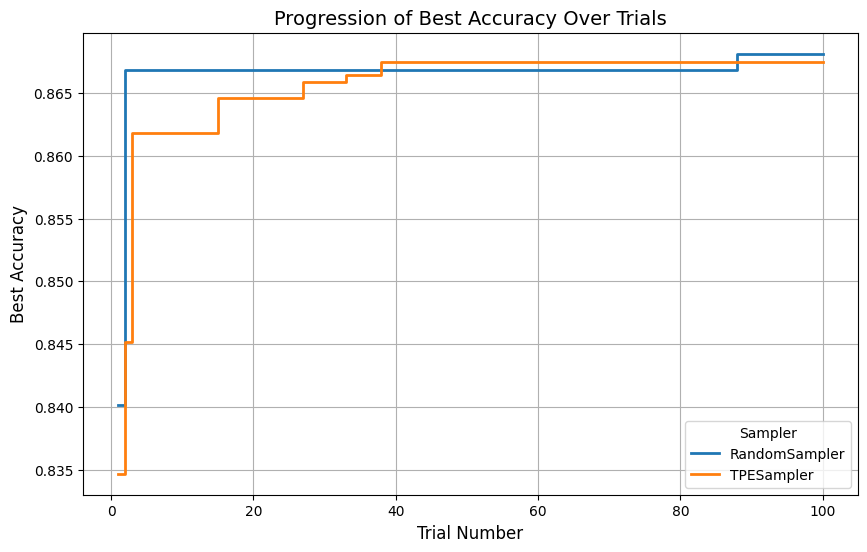

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load DataFrame
df = pd.read_csv("sampler_cumulative_results.csv")

df_cumulative = df.cummax()
df_cumulative["Trial"] = df.index + 1
csv_filename = "sampler_cumulative_results.csv"
df_cumulative.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")
df_melted = df_cumulative.melt(id_vars=["Trial"], var_name="Sampler", value_name="Best Accuracy So Far")


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x="Trial", y="Best Accuracy So Far", hue="Sampler", linewidth=2, drawstyle="steps-post")
plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("Best Accuracy", fontsize=12)
plt.title("Progression of Best Accuracy Over Trials", fontsize=14)
plt.grid(True)
plt.legend(title="Sampler")
plt.savefig("Sampler_Comparison.png")

In [1]:
import torch.nn as nn
import torch
from chop.nn.modules import Identity
from pathlib import Path
import dill
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr
from chop.tools import get_tokenized_dataset
from chop.tools import get_trainer
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from optuna.samplers import GridSampler, RandomSampler, TPESampler



checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"


dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)


/rds/general/user/jj21/home/.conda/envs/adls/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [16]:
def construct_model(trial, is_grid):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        if is_grid:
            chosen_val = trial.suggest_categorical(param, search_space[param])
            setattr(config, param, chosen_val) 
        else:
            chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
            setattr(config, param, search_space[param][chosen_idx])

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model


sampler_accuracy = {"RandomSampler":[], "TPESampler":[] , "GridSampler":[]}

def objective(trial, is_grid=False):

    # Define the model
    model = construct_model(trial, is_grid)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    sampler_accuracy[sampler_type].append(eval_results["eval_accuracy"]) 

    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


sampler_type = "GridSampler"
grid_search_space = search_space.copy()
# Letting gridsampler know the layers beforehand
config = AutoConfig.from_pretrained(checkpoint)
trial_model = AutoModelForSequenceClassification.from_config(config)
for name, layer in trial_model.named_modules():
    if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
        grid_search_space[f"{name}_type"] = grid_search_space['linear_layer_choices']
sampler = GridSampler(grid_search_space)
print("GridSampler")
study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)
study.optimize(
    lambda trial: objective(trial, is_grid=True),
    n_trials=100,
    timeout=60 * 60 * 24,
)
print(sampler_accuracy)

[I 2025-02-06 12:23:02,784] A new study created in memory with name: bert-tiny-nas-study


GridSampler


Step,Training Loss


[W 2025-02-06 12:23:56,285] Trial 0 failed with parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 128, 'intermediate_size': 2048, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>} because of the following error: Keyboard

KeyboardInterrupt: 